In [2]:
import numpy as np 
import cv2
import glob
import matplotlib.pyplot as plt

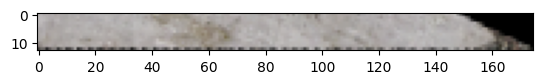

In [9]:
data_dir = "../data/poc_10_pictorial_compatibility/"
edge2original_image = {}
edge2extrpolated_image = {}

for file in glob.glob(data_dir+"*.png"):
    file_name = file.split("\\")[-1]
    splitted = file_name.split("_")
    splitted_dash = splitted[0].split("-")
    edge = "_".join(splitted_dash[4:])

    if "ext" in splitted[1]:
        edge2extrpolated_image[edge] = cv2.imread(file)
    elif "original" in splitted[1]:
        edge2original_image[edge] = cv2.imread(file)


plt.imshow(edge2original_image["P_9_E_2"])

In [10]:
potential_high_score_matings = [
    ("P_9_E_2","P_6_E_1"),
    ("P_9_E_0","P_7_E_1"),
    ("P_0_E_3","P_1_E_0")
]

In [11]:
def compatibility_v1(img1,img2):
    return 1

In [ ]:
for edge1,edge2 in potential_high_score_matings:
    score_side_1 = compatibility_v1(edge2original_image[edge1],
                                    edge2extrpolated_image[edge2])
    score_side_2 = compatibility_v1(edge2original_image[edge2],
                                    edge2extrpolated_image[edge1])